In [1]:
from odc.stac import stac_load, configure_rio
import dask
from pystac_client import Client
import geopandas as gpd
from shapely.geometry import Point, Polygon
from pyproj.crs import CRS 
import rioxarray as rxr
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
# client = dask.distributed.Client()
# configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)

from odc import stac
# stac.configure_s3_access(profile='fh-prod-users', requester_pays=True)

In [2]:
bbox = [-121.4990079250382, 38.09812886754961, -121.5017761753829, 38.09718420249281]
aoi_coordinates = {
    'Alfalfa': [
        (-121.504670, 38.100631),
        (-121.501246, 38.101757),
        (-121.498513, 38.098168),
        (-121.501920, 38.097003)
    ],
    'Corn': [
        (-121.4990079250382, 38.09812886754961),
        (-121.5014422113805, 38.10135642406711),
        (-121.5041218158785, 38.10040325584766),
        (-121.5017761753829, 38.09718420249281),
        (-121.5017761753829, 38.09718420249281),
    ],
}

aoi = aoi_coordinates['Corn']
poly = Polygon(aoi)
poly_gdf = gpd.GeoDataFrame({'geometry': [poly]}, crs=CRS.from_epsg(4326))
poly_gdf = poly_gdf.to_crs(crs=CRS.from_epsg(32610))



In [3]:
# eurl = 'https://earth-search.aws.element84.com/v1/'
# s2coll = "sentinel-s2-l2a-cogs"
# s2coll = "sentinel-2-l2a"

In [3]:
eurl = "https://earth-search.aws.element84.com/v1/"
s2coll = "sentinel-2-l2a"

s2_cat = Client.open(eurl)
s2_search = s2_cat.search(
    intersects={"type": "Point", "coordinates": [-121.50147, 38.0994]},
    datetime=["2022-04-01T00:00:00Z", "2022-08-31T23:59:59Z"],
    collections=[s2coll],
#     max_items=1,
#     limit=1
)

print(f"found {s2_search.matched()} items")

ds_s2_odc = stac_load(
    s2_search.item_collection(),
    bands=["red", "nir08"],
    chunks={"x": 1024, "y": 1024},
    groupby="solar_day",
    resolution=20,
)

print("datacube shape for one band: ", ds_s2_odc['nir08'].shape)
print("loaded datacube and exit.")

found 30 items
datacube shape for one band:  (30, 5490, 5490)
loaded datacube and exit.


In [4]:
ds_nir_clip = ds_s2_odc['nir08'].rio.clip(poly_gdf.geometry, all_touched=True, drop=True)
ds_red_clip = ds_s2_odc['red'].rio.clip(poly_gdf.geometry, all_touched=True, drop=True)
ds_red_clip

<xarray.DataArray 'red' (time: 30, y: 25, x: 24)>
dask.array<astype, shape=(30, 25, 24), dtype=uint16, chunksize=(1, 23, 24), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 4.218e+06 4.218e+06 ... 4.218e+06 4.218e+06
  * x            (x) float64 6.312e+05 6.312e+05 ... 6.316e+05 6.316e+05
  * time         (time) datetime64[ns] 2022-04-04T19:03:52.995000 ... 2022-08...
    spatial_ref  int32 0
Attributes:
    _FillValue:  0

In [5]:
ndvi_clip = (ds_nir_clip - ds_red_clip) / (ds_nir_clip + ds_red_clip)

c:\Users\Erik_Anderson\miniconda3\envs\ea-lst\Lib\site-packages\rasterio\warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


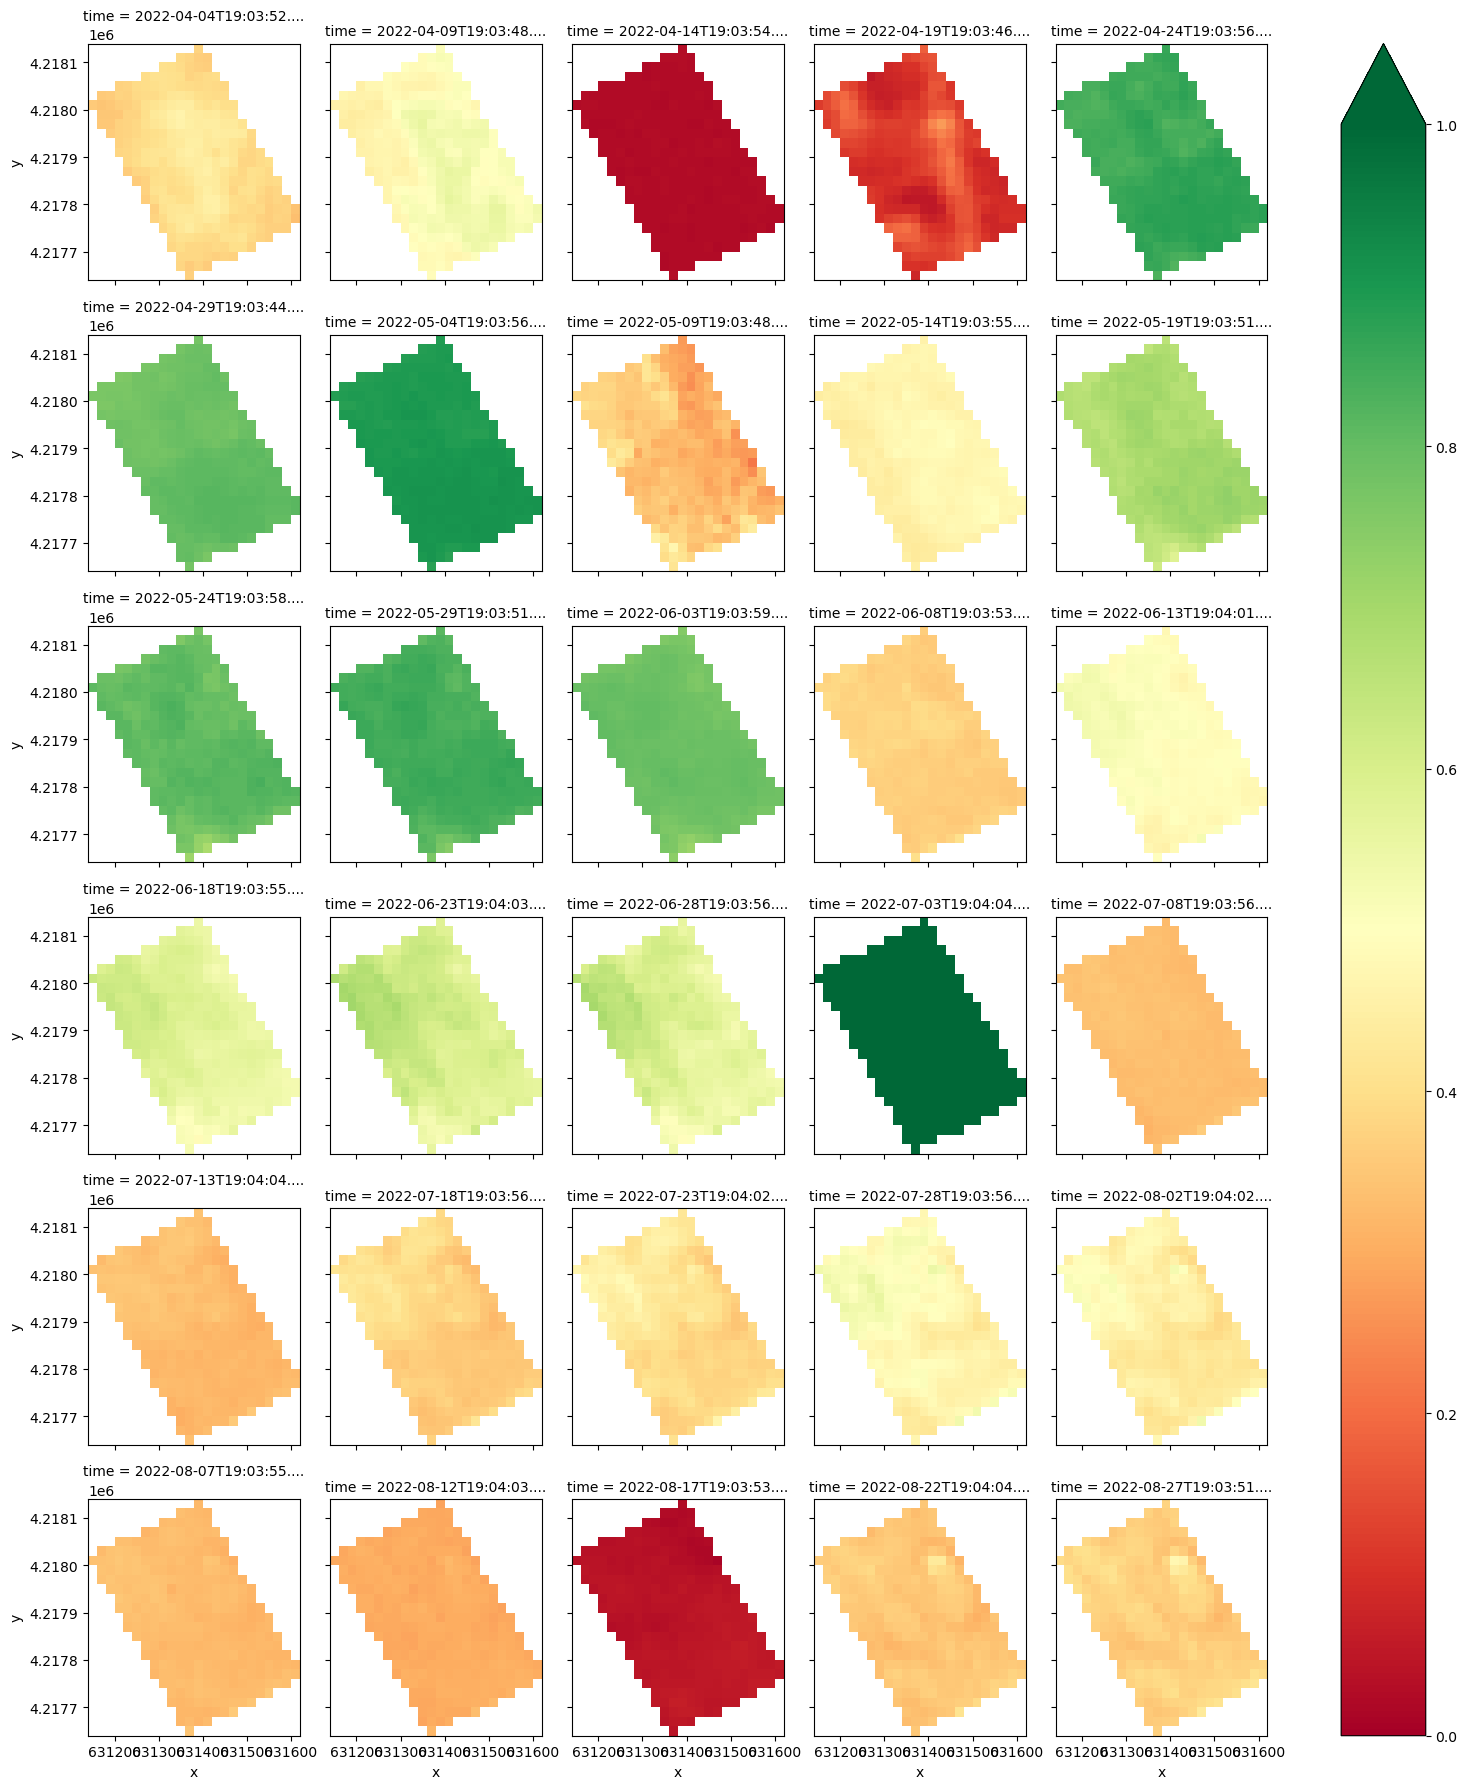

In [6]:
ndvi_clip.plot(x='x', y='y', col='time', col_wrap=5, cmap='RdYlGn', vmin=0, vmax=1)

## I am only doing this because of processing baseline version 4.0.0 change for Sentinel-2 which is in effect from Jan 2022 onward. 

In [7]:
mask =  ds_nir_clip==0

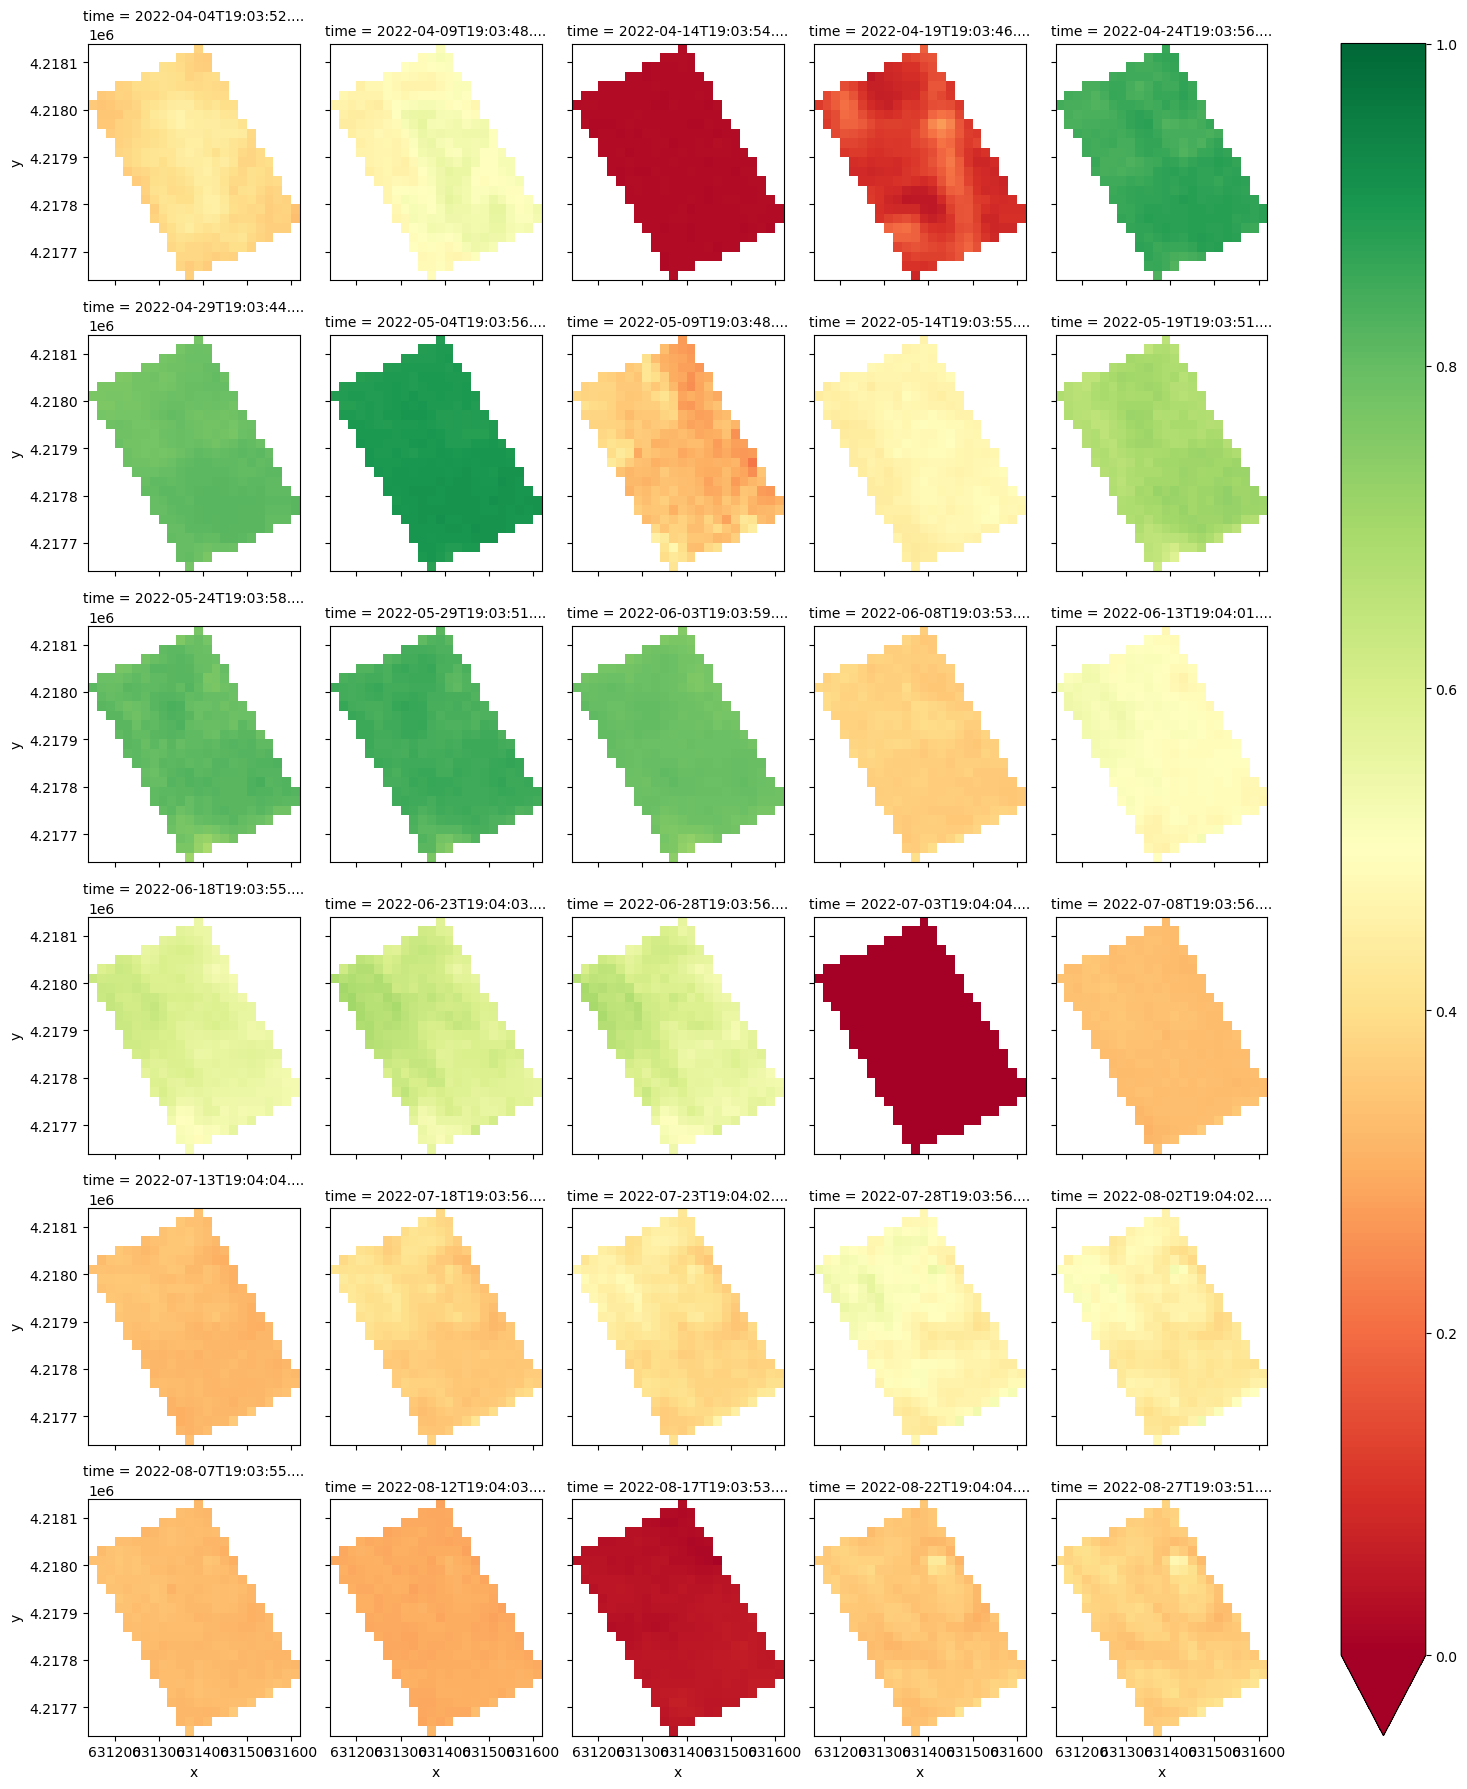

In [8]:
ds_nir_clip2 = (ds_nir_clip-0.1)*0.0001
ds_red_clip2 = (ds_red_clip-0.1)*0.0001
ndvi_clip2 = (ds_nir_clip2 - ds_red_clip2) / (ds_nir_clip2 + ds_red_clip2)
ndvi_clip2 = xr.where(mask, np.nan, ndvi_clip2)

ndvi_clip2.plot(x='x', y='y', col='time', col_wrap=5, cmap='RdYlGn', vmin=0, vmax=1)

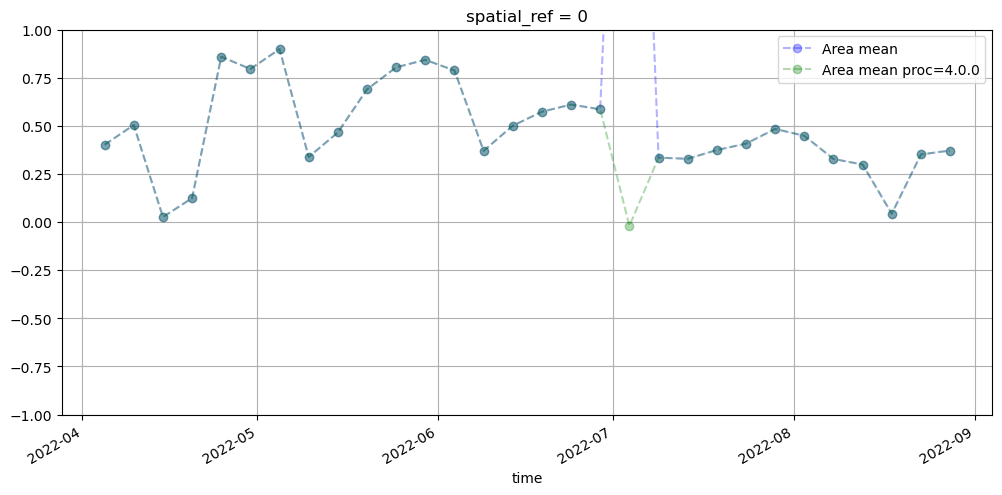

In [9]:
fig, ax = plt.subplots(figsize=(12,5))
ndvi_clip.mean(dim=('x', 'y')).plot(linestyle='--', alpha=0.3, marker='o', c='b', label='Area mean')
ndvi_clip2.mean(dim=('x', 'y')).plot(linestyle='--', alpha=0.3, marker='o', c='g', label='Area mean proc=4.0.0')
plt.ylim([-1,1])
plt.grid(True)
plt.legend()

Get the same data from prepped_inputs_s2 with the 15 day window

In [11]:
import json
import base64

In [12]:
with open('../secrets/creds.json') as f:
    creds = json.loads(f.read())
    
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

collections = ["prepped_inputs_s2_evaluation"]
search = catalog.search(
    collections = collections,
    intersects={"type": "Point", "coordinates": [-121.50147, 38.0994]},
    datetime=["2022-04-01T00:00:00Z", "2022-08-31T23:59:59Z"],
    max_items = 500
)

# items = list(search.items()) # for pystac-client >= 0.4.0
fh_items = list(search.get_all_items()) # for pystac-client < 0.4.0
fh_items.reverse() # make the results ascending in time


In [13]:
from FH_Hydrosat import FH_Hydrosat

In [14]:
point_wgs84 = Point(-121.50147, 38.0994)

In [15]:
# sample the s2 items
s2_res = FH_Hydrosat(fh_items, asset='surface_reflectance')
s2_red_ts = s2_res.point_time_series_from_items(point_wgs84, tol=40, nproc=6, band=2) 
s2_nir_ts = s2_res.point_time_series_from_items(point_wgs84, tol=40, nproc=6, band=6) 
s2_dt = s2_res.datetime

s2_red_area_ts = s2_res.area_time_series_from_items(poly_gdf, nproc=6, stat='mean', band=2)
s2_nir_area_ts = s2_res.area_time_series_from_items(poly_gdf, nproc=6, stat='mean', band=6)

using 6 processes to sample 28 assets
using 6 processes to sample 28 assets
using 6 processes to sample 28 assets
using 6 processes to sample 28 assets


In [16]:
import pandas as pd

In [17]:
s2_ndvi_ts = (np.array(s2_nir_ts) - np.array(s2_red_ts)) / (np.array(s2_nir_ts) + np.array(s2_nir_ts))

s2_ndvi_df = pd.DataFrame({'ndvi': s2_ndvi_ts,
                          'datetime': pd.to_datetime(s2_dt)}).sort_values(by='datetime')
s2_ndvi_df['date'] = [t.to_pydatetime().strftime('%Y-%m-%d') for t in s2_ndvi_df['datetime']]

s2_ndvi_df = s2_ndvi_df.set_index(s2_ndvi_df['date'])
s2_ndvi_df['color'] = 'red'

#####################################################
# do the same for the polygon

s2_ndvi_area_ts = (np.array(s2_nir_area_ts) - np.array(s2_red_area_ts)) / (np.array(s2_nir_area_ts) + np.array(s2_nir_area_ts))

s2_ndvi_area_df = pd.DataFrame({'ndvi': s2_ndvi_area_ts,
                          'datetime': pd.to_datetime(s2_dt)}).sort_values(by='datetime')
s2_ndvi_area_df['date'] = [t.to_pydatetime().strftime('%Y-%m-%d') for t in s2_ndvi_area_df['datetime']]

s2_ndvi_area_df = s2_ndvi_area_df.set_index(s2_ndvi_area_df['date'])
s2_ndvi_area_df['color'] = 'red'

C:\software\Anaconda3\envs\hydrosat\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


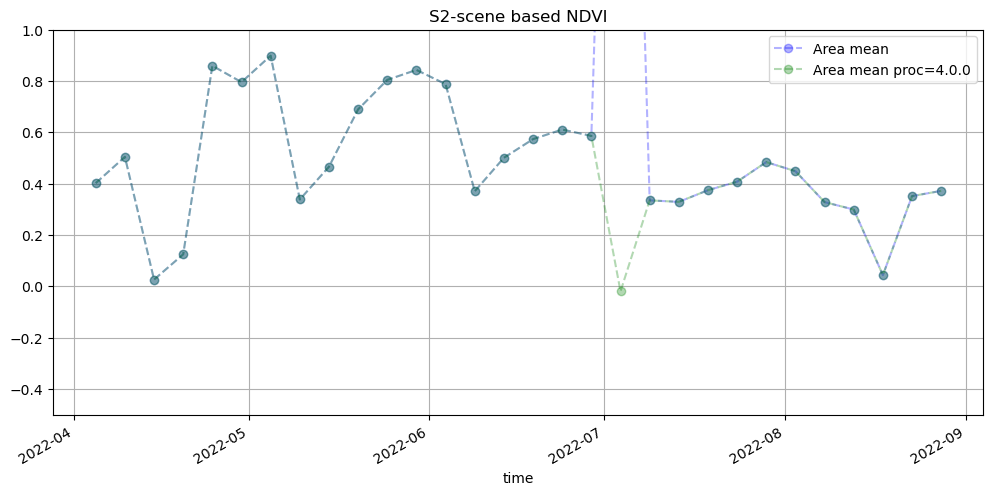

In [37]:
fig0, ax0 = plt.subplots(figsize=(12,5))
ndvi_clip.mean(dim=('x', 'y')).plot(linestyle='--', alpha=0.3, marker='o', c='b', label='Area mean')
ndvi_clip2.mean(dim=('x', 'y')).plot(linestyle='--', alpha=0.3, marker='o', c='g', label='Area mean proc=4.0.0')
plt.ylim([-.5,1])
plt.grid(True)
plt.legend()
plt.title('S2-scene based NDVI')
plt.show()

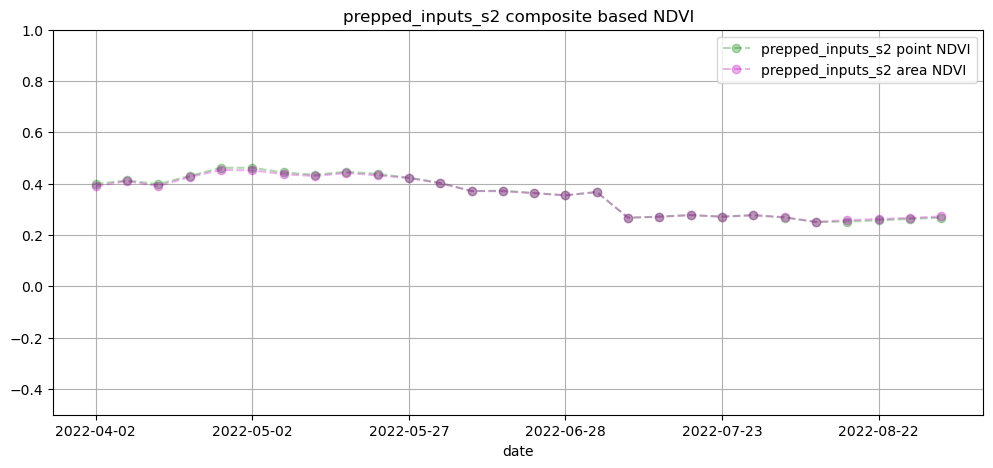

In [44]:
fig1, ax1 = plt.subplots(figsize=(12,5))
s2_ndvi_df.plot(ax=ax1, y='ndvi', linestyle='--', alpha=0.3, marker='o', c='g', label='prepped_inputs_s2 point NDVI')
s2_ndvi_area_df.plot(ax=ax1, y='ndvi', linestyle='--', alpha=0.3, marker='o', c='m', label='prepped_inputs_s2 area NDVI')
plt.ylim([-.5,1])
plt.grid(True)
plt.legend()
plt.title('prepped_inputs_s2 composite based NDVI')
plt.show()

## repeat for 2021

In [59]:
s2_search = s2_cat.search(
    intersects={"type": "Point", "coordinates": [-121.50147, 38.0994]},
    datetime=["2021-04-01T00:00:00Z", "2021-08-31T23:59:59Z"],
    collections=[s2coll],
#     max_items=1,
#     limit=1
)

print(f"found {s2_search.matched()} items")

ds_s2_odc = stac_load(
    s2_search.item_collection(),
    bands=["red", "nir08"],
    chunks={"x": 1024, "y": 1024},
    groupby="solar_day",
    crs=CRS(32610),
    resolution=20,
)

print("datacube shape for one band: ", ds_s2_odc['nir08'].shape)
print("loaded datacube and exit.")

found 48 items
datacube shape for one band:  (29, 5500, 5491)
loaded datacube and exit.


In [60]:
ds_nir_clip = ds_s2_odc['nir08'].rio.clip(poly_gdf.geometry, all_touched=True, drop=True)
ds_red_clip = ds_s2_odc['red'].rio.clip(poly_gdf.geometry, all_touched=True, drop=True)
ds_red_clip

<xarray.DataArray 'red' (time: 29, y: 25, x: 24)>
dask.array<astype, shape=(29, 25, 24), dtype=uint16, chunksize=(1, 23, 24), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 4.218e+06 4.218e+06 ... 4.218e+06 4.218e+06
  * x            (x) float64 6.312e+05 6.312e+05 ... 6.316e+05 6.316e+05
  * time         (time) datetime64[ns] 2021-04-04T19:03:49.289000 ... 2021-08...
    spatial_ref  int32 0
Attributes:
    _FillValue:  0

In [61]:
ndvi_clip = (ds_nir_clip - ds_red_clip) / (ds_nir_clip + ds_red_clip)

C:\software\Anaconda3\envs\hydrosat\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


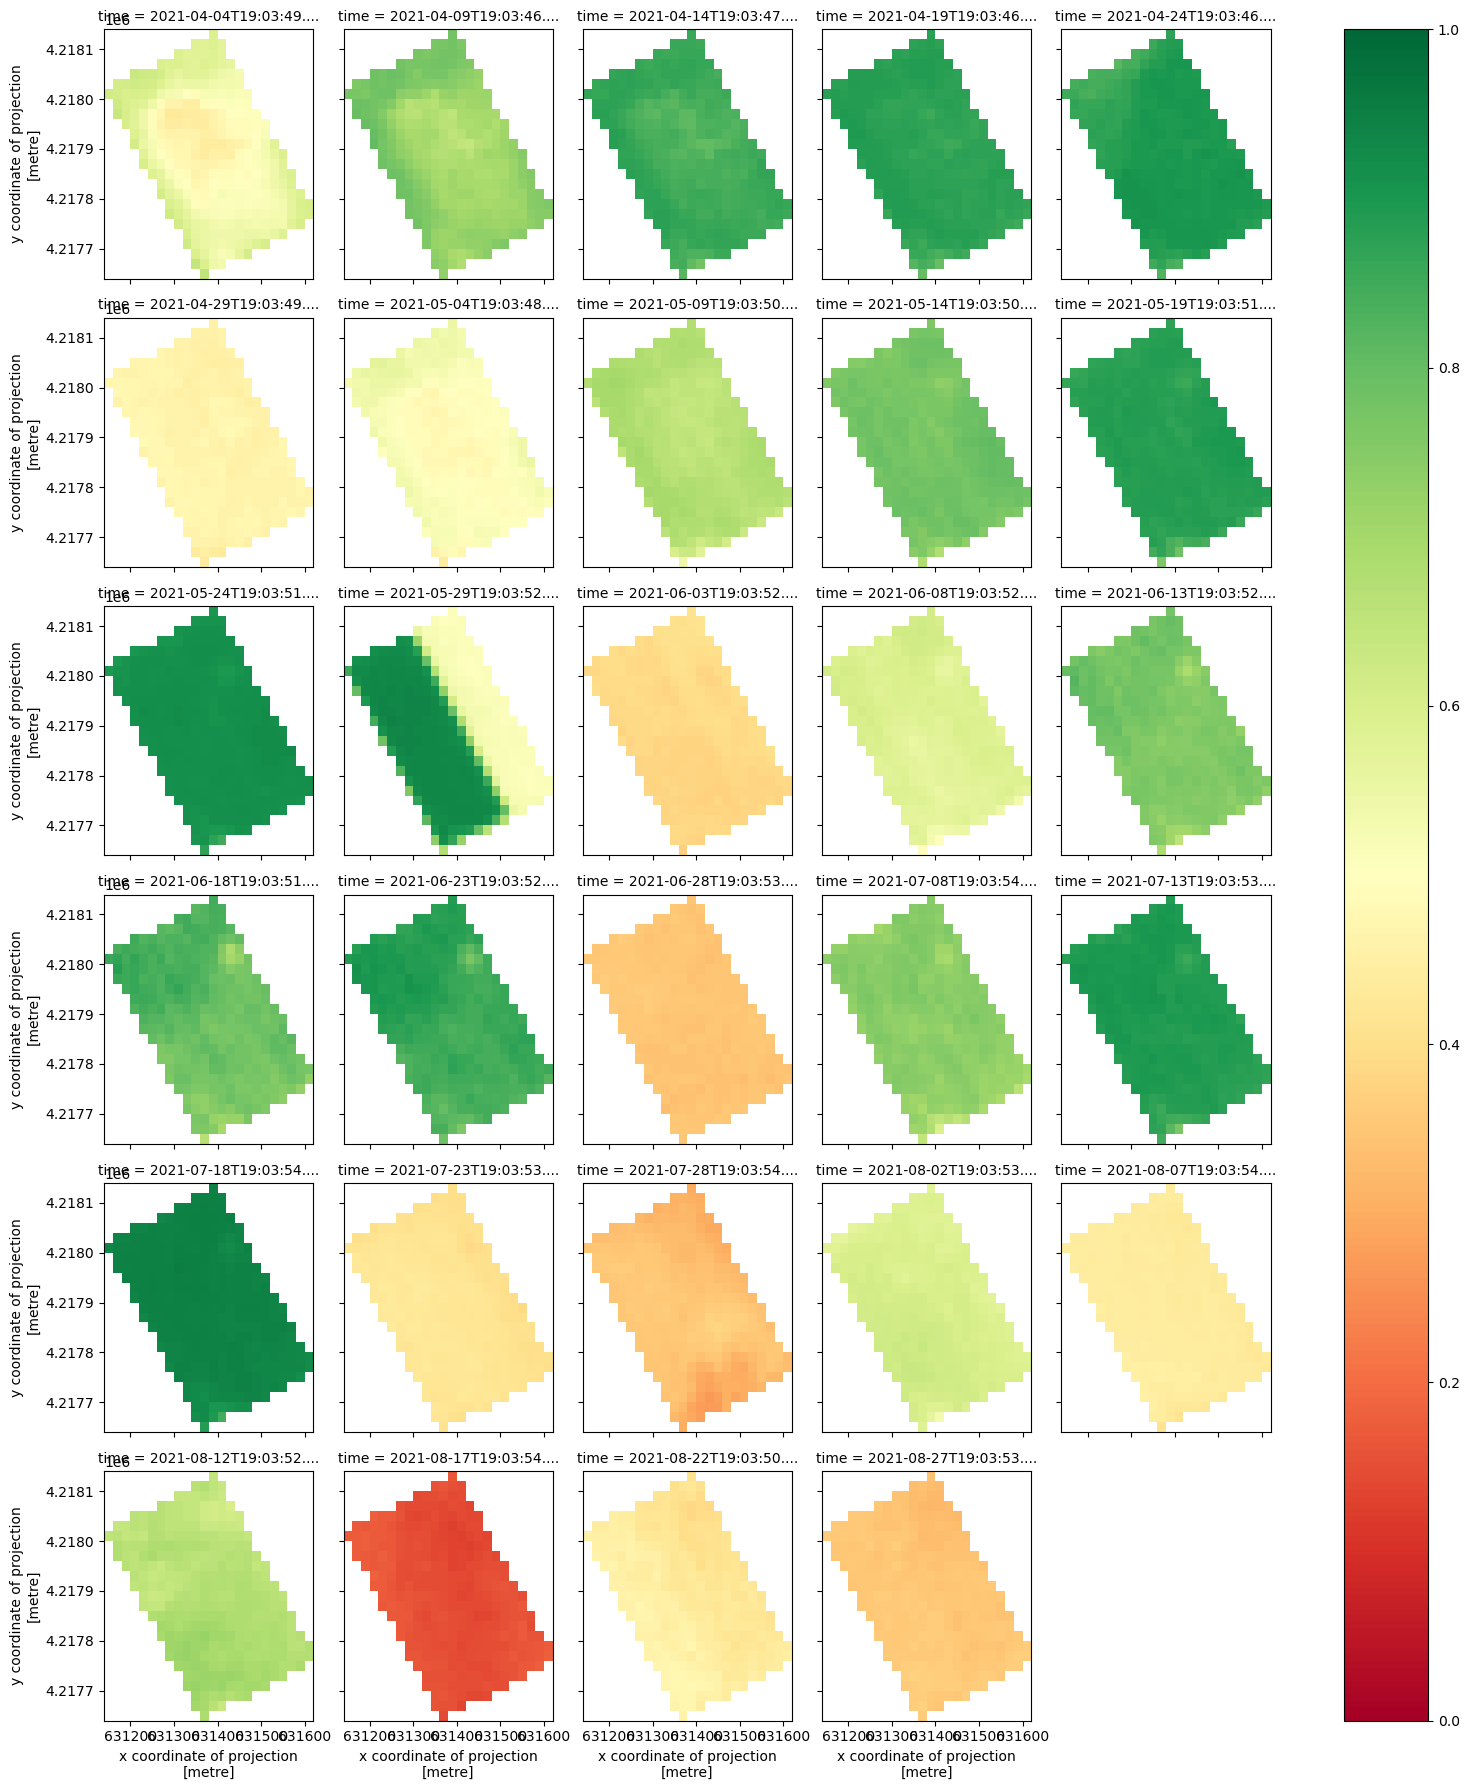

In [62]:
ndvi_clip.plot(x='x', y='y', col='time', col_wrap=5, cmap='RdYlGn', vmin=0, vmax=1)

In [63]:
mask =  ds_nir_clip==0

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ndvi_clip.mean(dim=('x', 'y')).plot(linestyle='--', alpha=0.3, marker='o', c='b', label='Area mean')
plt.ylim([-1,1])
plt.grid(True)
plt.legend()

Get the same data from prepped_inputs_s2 with the 15 day window

In [67]:
with open('../secrets/creds.json') as f:
    creds = json.loads(f.read())
    
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

collections = ["prepped_inputs_s2_evaluation"]
search = catalog.search(
    collections = collections,
    intersects={"type": "Point", "coordinates": [-121.50147, 38.0994]},
    datetime=["2021-04-01T00:00:00Z", "2021-08-31T23:59:59Z"],
    max_items = 500
)

# items = list(search.items()) # for pystac-client >= 0.4.0
fh_items = list(search.get_all_items()) # for pystac-client < 0.4.0
fh_items.reverse() # make the results ascending in time


In [69]:
point_wgs84 = Point(-121.50147, 38.0994)

In [70]:
# sample the s2 items
s2_res = FH_Hydrosat(fh_items, asset='surface_reflectance')
s2_red_ts = s2_res.point_time_series_from_items(point_wgs84, tol=40, nproc=6, band=2) 
s2_nir_ts = s2_res.point_time_series_from_items(point_wgs84, tol=40, nproc=6, band=6) 
s2_dt = s2_res.datetime

s2_red_area_ts = s2_res.area_time_series_from_items(poly_gdf, nproc=6, stat='mean', band=2)
s2_nir_area_ts = s2_res.area_time_series_from_items(poly_gdf, nproc=6, stat='mean', band=6)

using 6 processes to sample 19 assets
using 6 processes to sample 19 assets
using 6 processes to sample 19 assets
using 6 processes to sample 19 assets


In [72]:
s2_ndvi_ts = (np.array(s2_nir_ts) - np.array(s2_red_ts)) / (np.array(s2_nir_ts) + np.array(s2_nir_ts))

s2_ndvi_df = pd.DataFrame({'ndvi': s2_ndvi_ts,
                          'datetime': pd.to_datetime(s2_dt)}).sort_values(by='datetime')
s2_ndvi_df['date'] = [t.to_pydatetime().strftime('%Y-%m-%d') for t in s2_ndvi_df['datetime']]

s2_ndvi_df = s2_ndvi_df.set_index(s2_ndvi_df['date'])
s2_ndvi_df['color'] = 'red'

#####################################################
# do the same for the polygon

s2_ndvi_area_ts = (np.array(s2_nir_area_ts) - np.array(s2_red_area_ts)) / (np.array(s2_nir_area_ts) + np.array(s2_nir_area_ts))

s2_ndvi_area_df = pd.DataFrame({'ndvi': s2_ndvi_area_ts,
                          'datetime': pd.to_datetime(s2_dt)}).sort_values(by='datetime')
s2_ndvi_area_df['date'] = [t.to_pydatetime().strftime('%Y-%m-%d') for t in s2_ndvi_area_df['datetime']]

s2_ndvi_area_df = s2_ndvi_area_df.set_index(s2_ndvi_area_df['date'])
s2_ndvi_area_df['color'] = 'red'

In [ ]:
fig0, ax0 = plt.subplots(figsize=(12,5))
ndvi_clip.mean(dim=('x', 'y')).plot(linestyle='--', alpha=0.3, marker='o', c='b', label='Area mean')
plt.ylim([-.5,1])
plt.grid(True)
plt.legend()
plt.title('S2-scene based NDVI')
plt.show()

C:\software\Anaconda3\envs\hydrosat\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


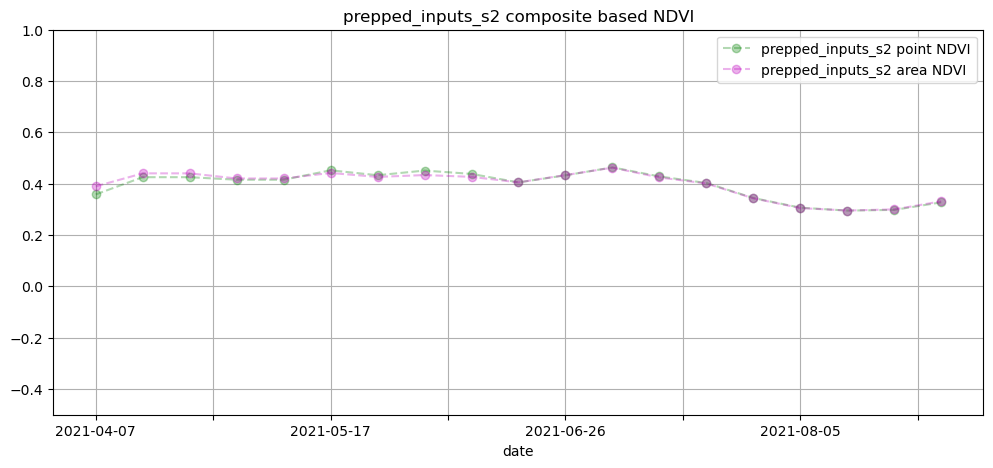

In [74]:
fig1, ax1 = plt.subplots(figsize=(12,5))
s2_ndvi_df.plot(ax=ax1, y='ndvi', linestyle='--', alpha=0.3, marker='o', c='g', label='prepped_inputs_s2 point NDVI')
s2_ndvi_area_df.plot(ax=ax1, y='ndvi', linestyle='--', alpha=0.3, marker='o', c='m', label='prepped_inputs_s2 area NDVI')
plt.ylim([-.5,1])
plt.grid(True)
plt.legend()
plt.title('prepped_inputs_s2 composite based NDVI')
plt.show()